In [1]:
import pandas as pd
import numpy as np
import torch as T
from torch import nn
import torch.nn.functional as F

import chemprop
import rdkit

import pickle as pkl
import gzip

from tqdm.notebook import tqdm
import argparse

In [2]:
import covid
import covid.datasets
from covid.modules import *
from covid.data import *
from covid.model import *
from covid.schedulers import LinearWarmupScheduler

from covid.modules.chemistry import MPNEncoder

In [ ]:
DROPOUT_RATE = 0.2
BATCH_SIZE = 16
BATCHES_PER_EPOCH = 1000

In [4]:
DEVICE = 'cuda'

In [5]:
chem_model = MPNEncoder(
    layers_per_message=3, 
    hidden_size=300,
    dropout=DROPOUT_RATE
)

In [6]:
protein_model = create_protein_model(dropout=DROPOUT_RATE)

In [7]:
model = CovidModel(chem_model, protein_model, dropout=DROPOUT_RATE)

In [8]:
model.to(DEVICE);

In [9]:
import random

In [10]:
import os, gzip
import pickle as pkl

def create_data_split(src_folder, dst_train_folder, dst_test_folder, pct_train=0.9, tolerance = 0.01):
    data = covid.datasets.StitchDataset(src_folder)
    data._deferred_load()
    
    while True:
        is_selected = pd.Series(False, index=data.all_data.index)

        chem_to_select = list(data.all_chemicals.keys())
        random.shuffle(chem_to_select)

        have_selected = set()
        num_selected = 0

        while num_selected/is_selected.shape[0] < (1-pct_train) and len(chem_to_select) > 0:
            chem = chem_to_select.pop(0)
            items_to_select = [chem]
            while items_to_select:
                item = items_to_select.pop(0)
                # print(len(have_selected), len(items_to_select), is_selected.mean())

                have_selected.add(item)
                new_selections = (
                    (data.all_data['item_id_a'] == item)
                    #| (data.all_data['item_id_b'] == item)
                )
                new_data = data.all_data.loc[new_selections]
                items_to_select.extend(
                    set(new_data['item_id_a'].values).union(
                        set()#new_data['item_id_b'].values
                    ).difference(have_selected)
                )
                is_selected = is_selected | new_selections
                num_selected += new_data.shape[0]

            # print(is_selected.mean())

        if is_selected.mean() <= (1-pct_train) + tolerance:
            break
        
        print(f"Test set outside of tolerance -- {is_selected.mean():0.3%} -- retrying...")
    
    print(f"Test set selected -- {is_selected.mean():0.3%}")
    
    train_data = data.all_data.loc[~is_selected]
    train_chem = {k:data.all_chemicals[k] for k in train_data['item_id_a'].unique()}
    train_prot = {k:data.all_proteins[k] for k in train_data['item_id_b'].unique()}
    
    test_data = data.all_data.loc[is_selected]
    test_chem = {k:data.all_chemicals[k] for k in test_data['item_id_a'].unique()}
    test_prot = {k:data.all_proteins[k] for k in test_data['item_id_b'].unique()}
    
    if not os.path.exists(dst_train_folder):
        os.mkdir(dst_train_folder)
        
    train_data.to_csv(os.path.join(dst_train_folder, 'stitch_preprocessed.csv.gz'), index=False)
    with gzip.open(os.path.join(dst_train_folder, 'stitch_proteins.pkl.gz'), 'wb') as f:
        pkl.dump(train_prot, f, pkl.HIGHEST_PROTOCOL)
    with gzip.open(os.path.join(dst_train_folder, 'stitch_chemicals.pkl.gz'), 'wb') as f:
        pkl.dump(train_chem, f, pkl.HIGHEST_PROTOCOL)
        
    if not os.path.exists(dst_test_folder):
        os.mkdir(dst_test_folder)
        
    test_data.to_csv(os.path.join(dst_test_folder, 'stitch_preprocessed.csv.gz'), index=False)
    with gzip.open(os.path.join(dst_test_folder, 'stitch_proteins.pkl.gz'), 'wb') as f:
        pkl.dump(test_prot, f, pkl.HIGHEST_PROTOCOL)
    with gzip.open(os.path.join(dst_test_folder, 'stitch_chemicals.pkl.gz'), 'wb') as f:
        pkl.dump(test_chem, f, pkl.HIGHEST_PROTOCOL)
        

In [11]:
if not os.path.exists('./data/training'):
    create_data_split('./data', './data/training', './data/final_holdout')
    
    for i in range(10):
        create_data_split('./data/training', f'./data/train_{i:02}', f'./data/valid_{i:02}')

In [12]:
def create_dataloader(data, sample_size=None):
    class SubSampler(T.utils.data.Sampler):
        def __init__(self, length, numsamples):
            self._length = length
            self._numsamples = min(numsamples, length)

        def __iter__(self):
            return iter(np.random.choice(self._length, self._numsamples, replace=False))

        def __len__(self):
            return self._numsamples

    return T.utils.data.DataLoader(
        data,
        batch_size=BATCH_SIZE,
        sampler=None if sample_size is None else SubSampler(len(data), sample_size),
        shuffle=True if sample_size is None else None,
        collate_fn = covid.datasets.collate_stitch_data
    )

In [13]:
data = covid.datasets.StitchDataset('./data/train_00')
dataloader = create_dataloader(data, BATCH_SIZE * BATCHES_PER_EPOCH)

In [27]:
validation_data = covid.datasets.StitchDataset('./data/valid_00')
validation_dataloader = create_dataloader(validation_data, BATCH_SIZE * 200)

In [15]:
class RandomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5,100),
            nn.ReLU(),
            nn.Linear(100,5),
            nn.Sigmoid()
        )
        
    def forward(self, chem_graphs, chem_features, proteins):
        batch_size = chem_graphs.n_mols
        input = T.rand((batch_size, 5), device=chem_features.device)
        return self.model(input)

In [16]:
#model = RandomModel().to(DEVICE) 

In [17]:
optim = T.optim.Adam(model.parameters(), lr=1e-4, betas=(0.95, 0.99))
scheduler = LinearWarmupScheduler(optim, 2000)

In [18]:
import matplotlib.pyplot as plt

In [19]:
from ipywidgets import widgets
from IPython.display import display

In [20]:
losses = []
valid_losses = []

In [21]:
valid_losses

[]

In [30]:
def plot_losses(losses, valid_losses, period=10, display_to=None):
    with plt.style.context('bmh'):
        fig, ax = plt.subplots()
        y = np.reshape(losses[:((len(losses)//period)*period)],(-1,period)).mean(1)
        x = np.linspace(0, len(valid_losses)-1, y.shape[0])
        ax.plot(x, y, lw=1, alpha=0.75, label='model (training)', c='C0')
        ax.plot(np.arange(len(valid_losses)), valid_losses, label='model (validation)', c='C1')
        ax.plot((x[0], x[-1]), (0.358, 0.358), c='g', ls=':', lw=1.5, label='random baseline')
        ax.legend()
        if display_to is not None:
            with display_to:
                display(fig)
            plt.close(fig)


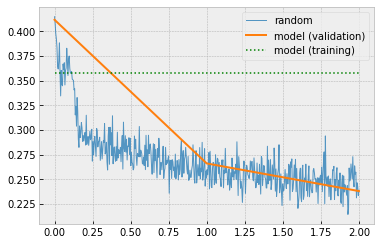

In [31]:
plot_losses(losses, valid_losses, 20)

In [24]:
def run_model(batch):
    chem_graphs, chem_features, proteins, target = batch
    
    chem_graphs = chem_graphs.to(DEVICE)
    chem_features = chem_features.to(DEVICE)
    proteins = proteins.to(DEVICE)

    weights = (target * 0.0015).clamp(1e-3, 1.0)
    weights[target == 0] = 0.5

    weights = weights.to(DEVICE)
    
    target = (1.0*(target > 0)).to(DEVICE)
    
    result = model(chem_graphs, chem_features, proteins)

    loss = F.binary_cross_entropy(result, target, weight=weights)
    return result, target, loss

In [25]:
def get_validation_loss():
    model.eval()
    
    total_loss = 0.0
    total_div = 0
    
    for batch in tqdm(validation_dataloader, leave=False):
        chem_graphs, chem_features, proteins, target = batch
        result, _, loss = run_model(batch)
        total_loss += loss.item() * result.shape[0]
        total_div += result.shape[0]
        
    return total_loss / total_div

In [28]:
valid_losses.append(get_validation_loss())

In [ ]:
chart_area = widgets.Output()
display(chart_area)

for epoch in tqdm(range(100)):
    idx = 0
    
    model.train()
    for batch in tqdm(dataloader, leave=False, total=BATCHES_PER_EPOCH):

        model.zero_grad()
        _, _, loss = run_model(batch)

        loss.backward()
        losses.append(loss.item())

        optim.step()
        scheduler.step()
            
        idx += 1
    
    valid_losses.append(get_validation_loss())
    
    chart_area.clear_output()
    plot_losses(losses, valid_losses, max(10, len(losses)//2000), chart_area)
    #     if idx >= 10:
    #         break

Output()

In [ ]:
np.reshape(losses, (-1,5))

In [ ]:
plt.plot(losses)